## Configuration

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

In [3]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2024, 10, 29), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [4]:
merged_df, e_price_df = get_datasets()

## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [5]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [6]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df)
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

print(features_interval_df.describe())

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value, prediction_date_picker.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value, prediction_date_picker.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



              Price       Biomass     Hard Coal         Hydro       Lignite   
count  53161.000000  53161.000000  53161.000000  53161.000000  53161.000000  \
mean      93.402616      0.082565      0.083275      0.038190      0.178598   
std       97.838578      0.017816      0.051783      0.014154      0.063812   
min     -500.000000      0.046099      0.004782      0.009522      0.034065   
25%       36.490000      0.069619      0.041829      0.028329      0.131726   
50%       62.430000      0.079192      0.068767      0.035253      0.187467   
75%      110.710000      0.091900      0.116213      0.045083      0.225959   
max      871.000000      0.195352      0.276600      0.127235      0.360442   

        Natural Gas       Nuclear         Other  Pumped storage generation   
count  53161.000000  53161.000000  53161.000000               53161.000000  \
mean       0.159447      0.076687      0.046927                   0.011773   
std        0.047908      0.054535      0.010397       

In [7]:
X_train.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-07-09 08:00:00,8,191,1,98.88,103.046667,101.4925,98.726,97.461667,96.835714,96.72625,...,0.0,0.036821,0.019896,0.358696,0.021383,0.061455,18.923477,0.0,20.562017,442.97348


In [8]:
X_val.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-10-28 23:00:00,23,302,0,106.185,109.32,113.0375,119.654,124.511667,126.882857,126.5475,...,0.0,0.045137,0.000688,0.0,0.031154,0.207098,10.869131,0.004348,23.55251,0.0


In [9]:
X_test.tail(1)

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2024-10-29 23:00:00,23,303,1,110.585,115.073333,121.455,137.928,157.846667,176.125714,180.7,...,0.0,0.046156,0.000599,0.0,0.040935,0.102369,11.390869,0.03913,25.068104,0.0


In [10]:
# plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
# plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [11]:
X_train

,hour,dayofyear,dayofweek,ma_2_hours,ma_3_hours,ma_4_hours,ma_5_hours,ma_6_hours,ma_7_hours,ma_8_hours,...,Nuclear,Other,Pumped storage generation,Solar,Wind offshore,Wind onshore,temperature_2m,precipitation,wind_speed_100m,direct_radiation
2018-10-01 00:00:00,0,274,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.142107,0.041383,0.003477,0.000000,0.029572,0.078357,6.821304,0.000000,35.251360,0.000000
2018-10-01 01:00:00,1,274,0,57.815,NaN,NaN,NaN,NaN,NaN,NaN,...,0.142376,0.041972,0.003478,0.000000,0.037920,0.073151,5.853913,0.000000,35.439972,0.000000
2018-10-01 02:00:00,2,274,0,53.755,55.680000,NaN,NaN,NaN,NaN,NaN,...,0.142441,0.041791,0.003471,0.000000,0.038929,0.071471,5.714783,0.000000,36.011060,0.000000
2018-10-01 03:00:00,3,274,0,49.395,51.630000,53.6050,NaN,NaN,NaN,NaN,...,0.140053,0.041441,0.003452,0.000000,0.039751,0.075943,5.443044,0.000000,35.883137,0.000000
2018-10-01 04:00:00,4,274,0,47.485,48.793333,50.6200,52.402,NaN,NaN,NaN,...,0.138012,0.040888,0.003391,0.000000,0.045451,0.082545,5.245217,0.000000,35.099083,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09 04:00:00,4,191,1,89.400,90.626667,91.9600,94.672,94.230000,97.004286,106.59000,...,0.000000,0.055228,0.006125,0.000051,0.013151,0.187688,12.414783,0.000000,27.777845,6.941588
2024-07-09 05:00:00,5,191,1,92.245,91.876667,92.1775,92.934,95.031667,94.601429,96.98250,...,0.000000,0.053371,0.004659,0.009468,0.014178,0.192206,13.614783,0.008696,26.208328,60.738620
2024-07-09 06:00:00,6,191,1,104.105,98.623333,96.7525,96.018,96.008333,97.367143,96.69875,...,0.000000,0.047080,0.027944,0.074320,0.018718,0.158681,15.219131,0.000000,24.368608,163.985930
2024-07-09 07:00:00,7,191,1,107.570,103.990000,99.9075,98.154,97.308333,97.115714,98.16625,...,0.000000,0.041262,0.038524,0.201883,0.020233,0.108641,17.134348,0.000000,21.262787,289.391400


In [12]:
lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [13]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)

[0]	validation_0-rmse:86.89350
[25]	validation_0-rmse:20.50316
[50]	validation_0-rmse:9.03190
[75]	validation_0-rmse:7.62713
[100]	validation_0-rmse:7.38859
[125]	validation_0-rmse:7.34098
[149]	validation_0-rmse:7.30118
[0]	validation_0-mae:75.28754
[25]	validation_0-mae:16.35119
[50]	validation_0-mae:5.28599
[75]	validation_0-mae:3.80450
[100]	validation_0-mae:3.65505
[125]	validation_0-mae:3.63661
[149]	validation_0-mae:3.63252


### Prophet

In [14]:
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0,
    holidays_prior_scale = 1.0,
    seasonality_mode= 'multiplicative'
)

#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=100)
model.add_seasonality(name='monthly', period=30.5, fourier_order=100)
model.add_seasonality(name='yearly', period=365, fourier_order=100)

# Add time-based regressors

for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

model.fit(train_data)


15:09:59 - cmdstanpy - INFO - Chain [1] start processing
15:12:02 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
test_data = test.reset_index().rename(columns={"index": "ds"}).dropna()
test_data.drop(columns=["Price"])
prophet_predictions = model.predict(test_data)["yhat"]

print(prophet_predictions)

0     101.072315
1      99.474189
2      98.740221
3      97.361036
4      99.505064
5     110.111829
6     130.921030
7     149.594475
8     156.547930
9     129.721307
10    117.570798
11    115.329929
12    105.828473
13    112.260381
14    133.169825
15    163.503130
16    204.655506
17    266.759786
18    278.682580
19    207.883736
20    142.158015
21    113.122445
22    119.552089
23    105.347553
Name: yhat, dtype: float64


## Results

### Errors

In [17]:
calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

            Model      MAE       MSE     RMSE     MAPE
Linear Regression 5.144720 60.276365 7.763785 3.149475
          Prophet 4.735902 52.938071 7.275855 2.799088
          XGBoost 4.110762 38.732085 6.223511 2.544842


### Plots

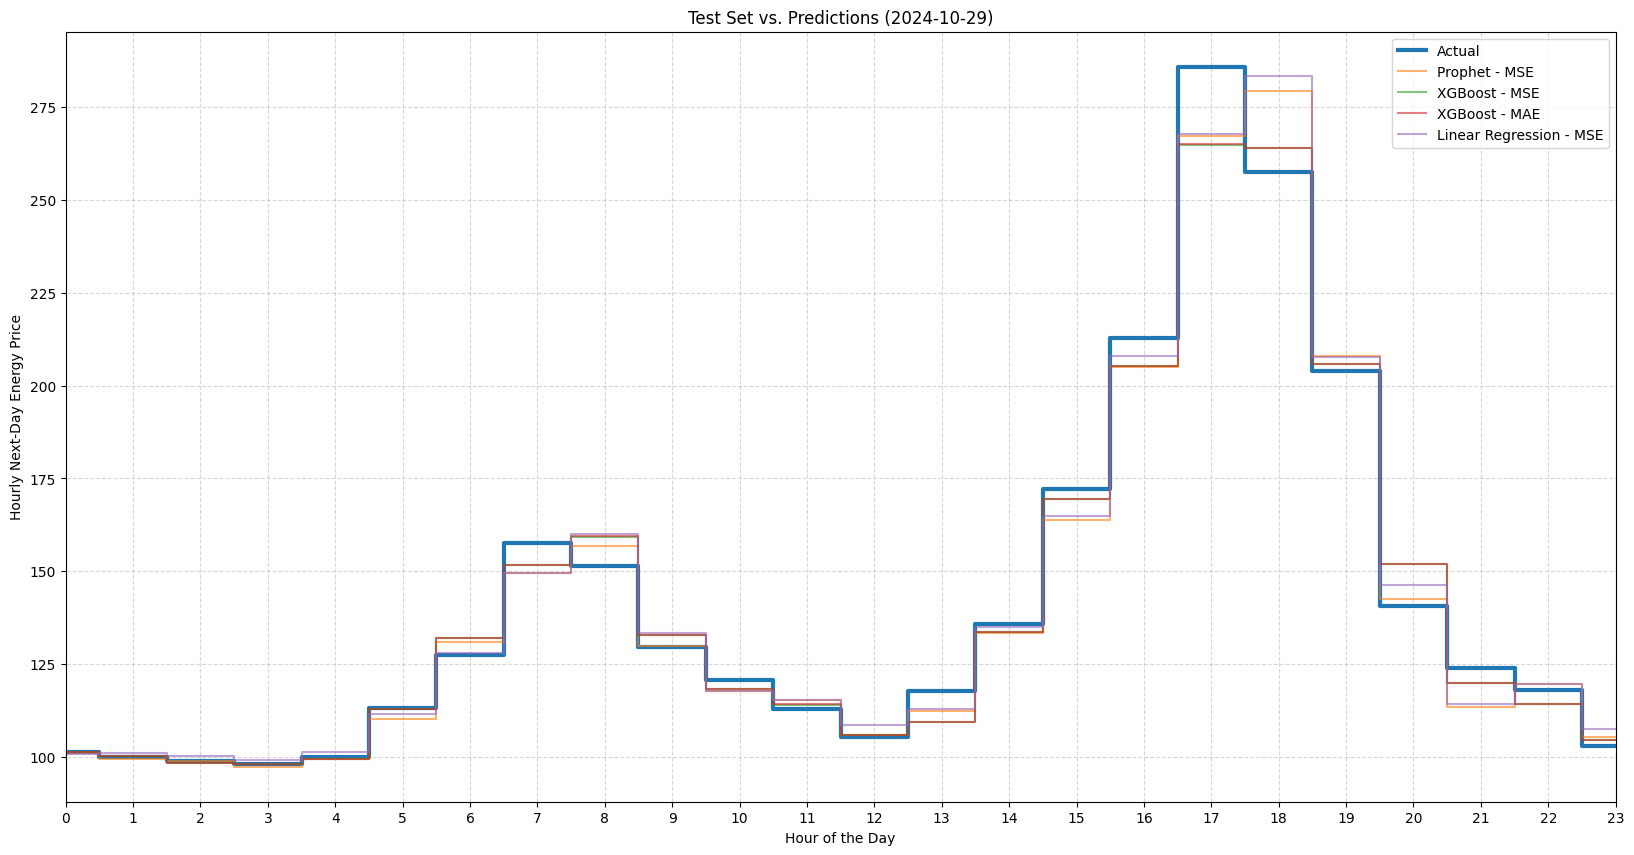

In [ ]:
predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

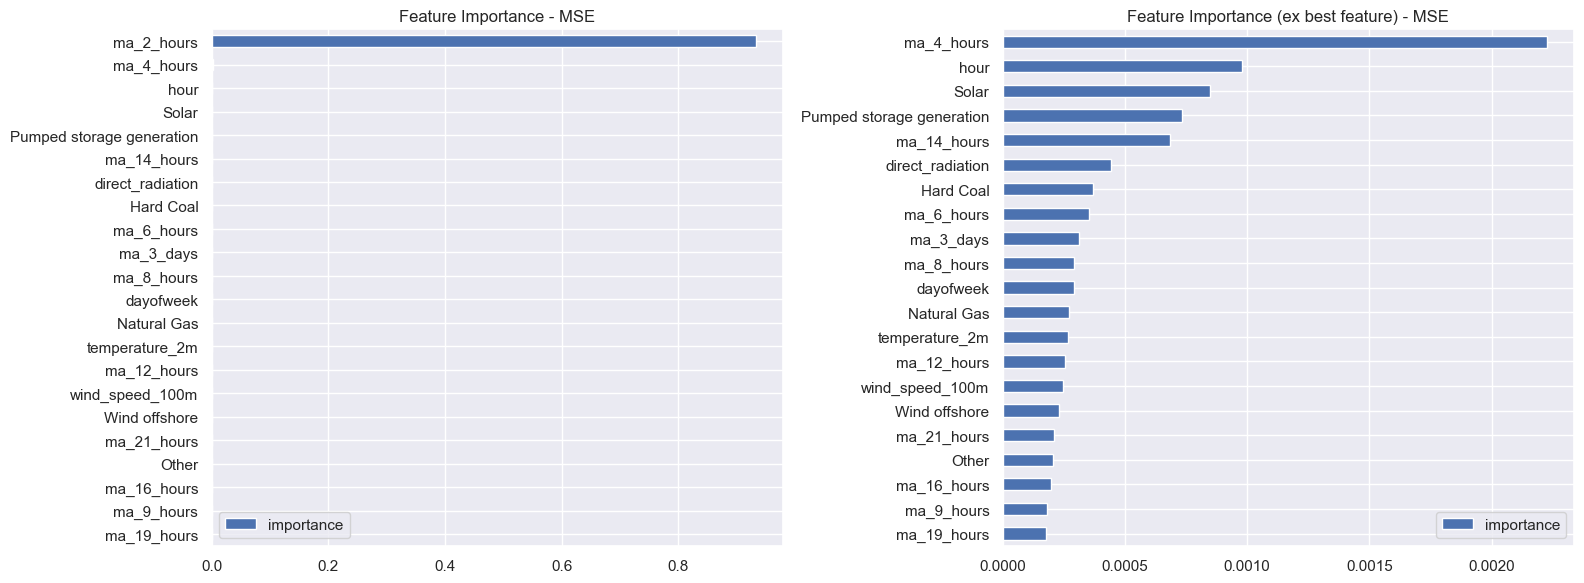

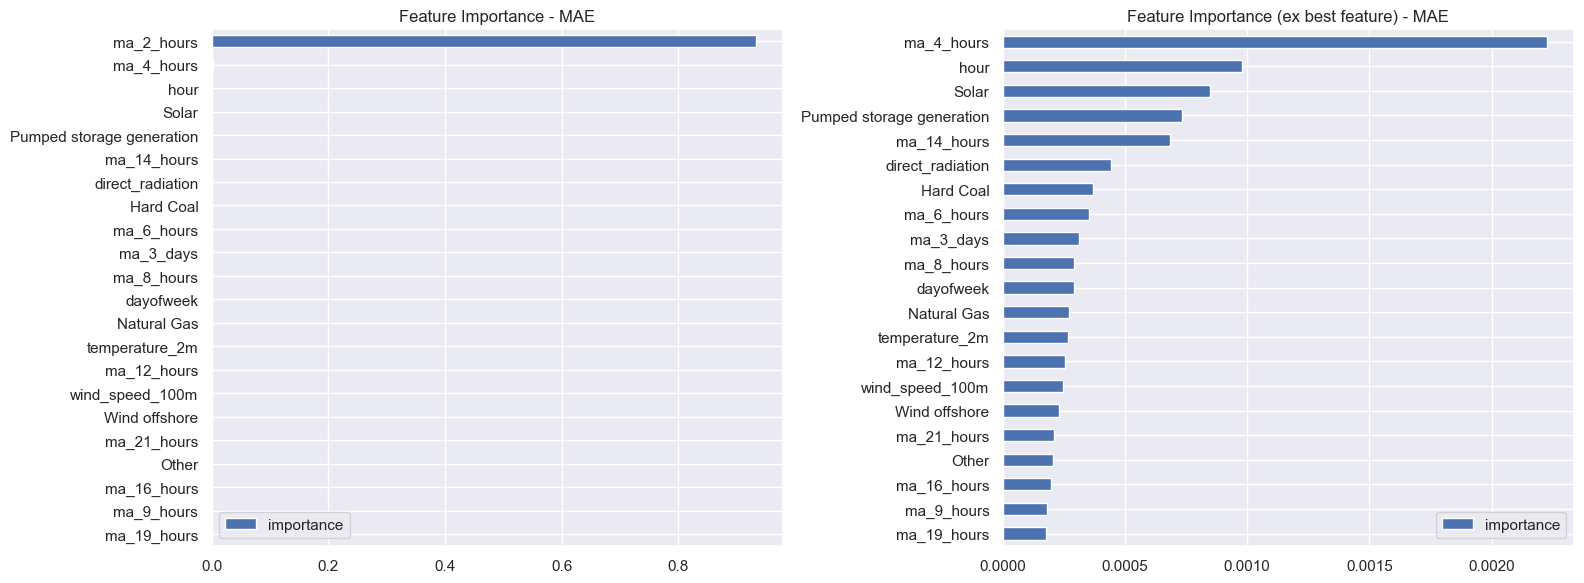

In [ ]:
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")